In [1]:
import matplotlib.pyplot as plt
import fraud_detection.viz.model_plots as viz
import fraud_detection.models.compare  as cp
from fraud_detection.data.loader import DataHandler
from fraud_detection.models.pipeline import build_pipeline
from fraud_detection.models.train import train_and_evaluate
from fraud_detection.core.settings import settings

In [2]:
# Test_original Data
test_original = DataHandler.from_registry(
    "DATA", "processed_dir", "test_original.parquet").load()

# Train_original Data
train_original = DataHandler.from_registry(
    "DATA", "processed_dir", "train_original.parquet").load()

# Train_resampled Data
train_resampled = DataHandler.from_registry(
    "DATA", "processed_dir", "train_resampled.parquet").load()

In [3]:
print("Train (original):", train_original.shape)
print("Train (resampled):", train_resampled.shape)
print("Test (original):", test_original.shape)

print("\nClass distribution (original train):")
print(train_original["class"].value_counts(normalize=True))

print("\nClass distribution (resampled train):")
print(train_resampled["class"].value_counts(normalize=True))

Train (original): (120889, 140)
Train (resampled): (219136, 140)
Test (original): (30223, 140)

Class distribution (original train):
class
0    0.906352
1    0.093648
Name: proportion, dtype: float64

Class distribution (resampled train):
class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [4]:
FEATURES = settings.get("features")

TARGET = FEATURES["target"]


X_train_orig = train_original.drop(columns=[TARGET])
y_train_orig = train_original[TARGET]

X_train_res = train_resampled.drop(columns=[TARGET])
y_train_res = train_resampled[TARGET]

X_test = test_original.drop(columns=[TARGET])
y_test = test_original[TARGET]

#### Training and Evalute on Original Data

In [5]:
results = {}
lr_pipe = build_pipeline("logistic_regression")

_, metrics_lr, _ = train_and_evaluate(
    pipeline=lr_pipe,
    X_train=X_train_orig,
    y_train=y_train_orig,
    X_test=X_test,
    y_test=y_test,
    optimize_threshold=True,
    threshold_metric="f1",
    model_name="Logistic",
    registered_model_name="credit_card_model"
)

results["Logistic Regression"] = metrics_lr

d:\10Acadamy\Week 5&6\Tasks\fraud-detection\.venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2025/12/27 21:27:15 INFO mlflow.tracking.fluent: Experiment with name 'fraud_detection_models' does not exist. Creating a new experiment.
d:\10Acadamy\Week 5&6\Tasks\fraud-detection\.venv\Lib\site-packages\mlflow\tracking\_model_registry\utils.py:215: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') 

### Train and Evaluate on SMOTE Resampled Data

In [6]:
rf_pipe = build_pipeline("random_forest")

_, metrics_rf, _ = train_and_evaluate(
    pipeline=rf_pipe,
    X_train=X_train_res,
    y_train=y_train_res,
    X_test=X_test,
    y_test=y_test,
    optimize_threshold=True,
    threshold_metric="f1",
    model_name="Random Forest",
    registered_model_name="credit_card_model"
)

results["Random Forest"] = metrics_rf

Registered model 'credit_card_model' already exists. Creating a new version of this model...
Created version '2' of model 'credit_card_model'.


In [7]:
xgb_pipe = build_pipeline("xgboost")

_, metrics_xgb, _ = train_and_evaluate(
    pipeline=xgb_pipe,
    X_train=X_train_res,
    y_train=y_train_res,
    X_test=X_test,
    y_test=y_test,
    optimize_threshold=True,
    threshold_metric="f1",
    model_name="XGBoost",
    registered_model_name="credit_card_model"
)

results["XGBoost"] = metrics_xgb

Registered model 'credit_card_model' already exists. Creating a new version of this model...
Created version '3' of model 'credit_card_model'.


In [10]:
comparison_df = cp.compare_models(results)
scored_df = cp.score_models(results)

best_model, best_metrics, reason = cp.select_best_model(results)

print(comparison_df)
print(scored_df)
print(reason)

                       auc_pr   roc_auc        f1  precision    recall  \
model                                                                    
XGBoost              0.712837  0.840240  0.690428   0.944206  0.544170   
Random Forest        0.709317  0.840779  0.601399   0.519404  0.714134   
Logistic Regression  0.649050  0.835967  0.662275   0.874710  0.532862   

                     threshold  
model                           
XGBoost               0.456518  
Random Forest         0.286489  
Logistic Regression   0.783867  
                     AUC_PR  F1  Precision  Recall  Interpretability  \
model                                                                  
XGBoost                  30  20         15       5                 5   
Random Forest            30  15          5      15                 7   
Logistic Regression      10  15         10       5                10   

                     Threshold  Total  
model                                  
XGBoost                

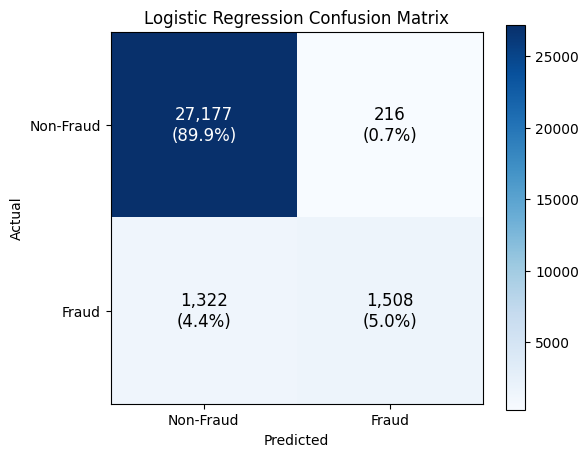

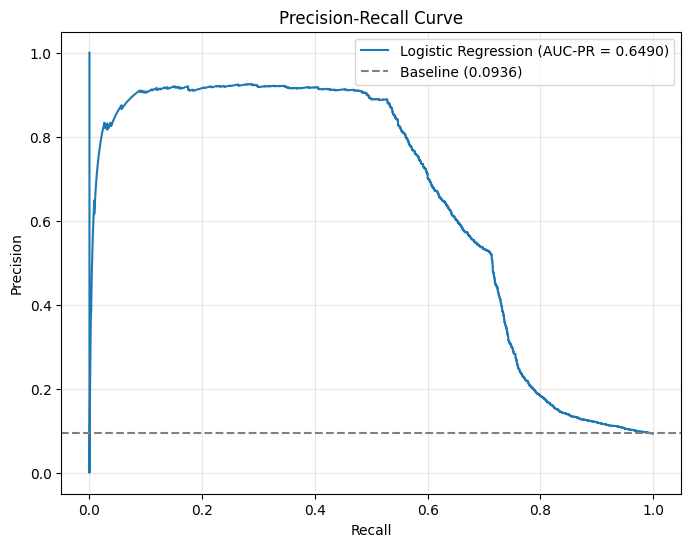

              precision    recall  f1-score       support
Non-Fraud      0.953612  0.992115  0.972483  27393.000000
Fraud          0.874710  0.532862  0.662275   2830.000000
accuracy       0.949112  0.949112  0.949112      0.949112
macro avg      0.914161  0.762488  0.817379  30223.000000
weighted avg   0.946224  0.949112  0.943436  30223.000000


In [11]:
# Predicted probabilities and labels using the optimized threshold
y_proba = lr_pipe.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= metrics_lr["threshold"]).astype(int)

# 1️⃣ Confusion Matrix
ax = viz.plot_confusion_matrix(
    y_test.values, y_pred, title="Logistic Regression Confusion Matrix")
plt.show()

# 2️⃣ Precision-Recall Curve
ax = viz.plot_precision_recall_curve(
    y_test.values, y_proba, model_name="Logistic Regression")
plt.show()

# 3️⃣ Classification Report
report_df = viz.get_classification_report_df(y_test.values, y_pred)
print(report_df)

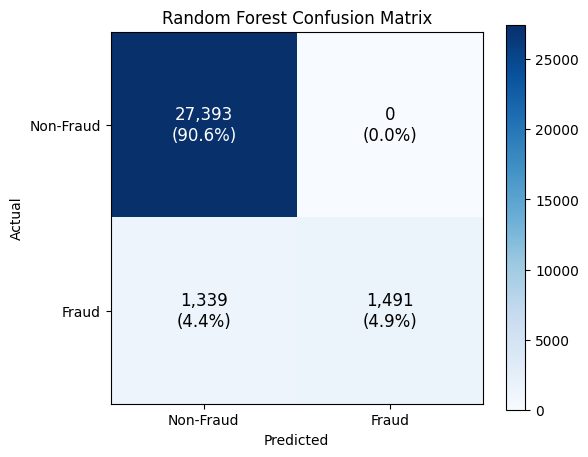

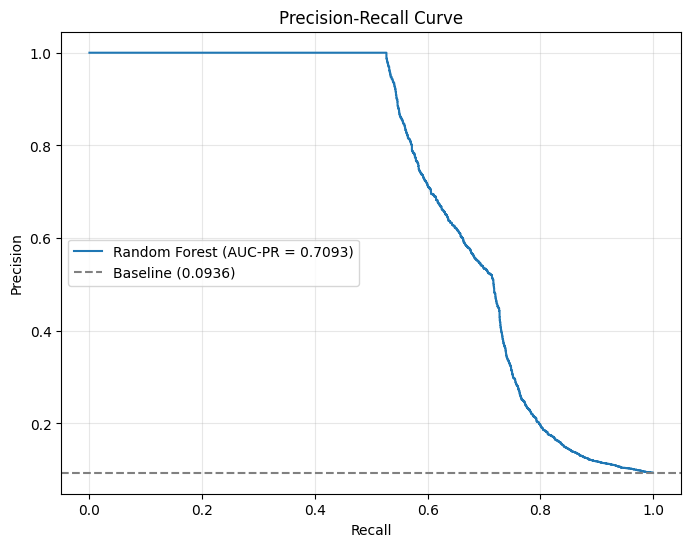

              precision    recall  f1-score       support
Non-Fraud      0.953397  1.000000  0.976143  27393.000000
Fraud          1.000000  0.526855  0.690118   2830.000000
accuracy       0.955696  0.955696  0.955696      0.955696
macro avg      0.976698  0.763428  0.833130  30223.000000
weighted avg   0.957761  0.955696  0.949360  30223.000000


In [12]:
# Predicted probabilities and labels using the optimized threshold
y_proba = rf_pipe.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= metrics_lr["threshold"]).astype(int)

# 1️⃣ Confusion Matrix
ax = viz.plot_confusion_matrix(
    y_test.values, y_pred, title="Random Forest Confusion Matrix")
plt.show()

# 2️⃣ Precision-Recall Curve
ax = viz.plot_precision_recall_curve(
    y_test.values, y_proba, model_name="Random Forest")
plt.show()

# 3️⃣ Classification Report
report_df = viz.get_classification_report_df(y_test.values, y_pred)
print(report_df)

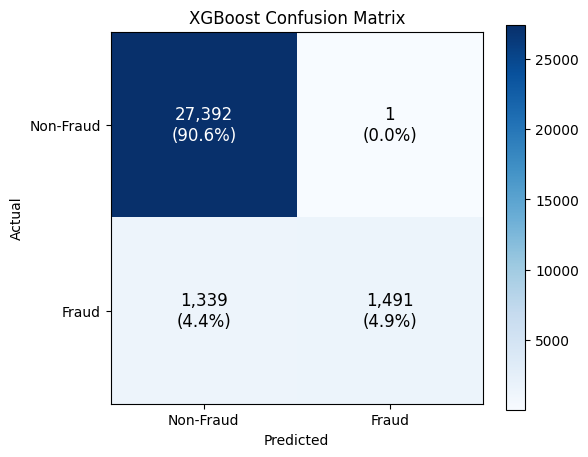

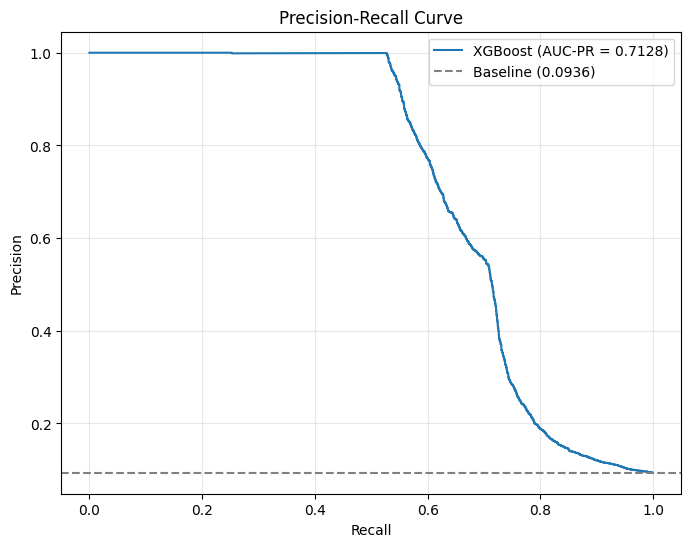

              precision    recall  f1-score       support
Non-Fraud      0.953395  0.999963  0.976124  27393.000000
Fraud          0.999330  0.526855  0.689958   2830.000000
accuracy       0.955663  0.955663  0.955663      0.955663
macro avg      0.976363  0.763409  0.833041  30223.000000
weighted avg   0.957696  0.955663  0.949328  30223.000000


In [13]:
# Predicted probabilities and labels using the optimized threshold
y_proba = xgb_pipe.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= metrics_lr["threshold"]).astype(int)

# 1️⃣ Confusion Matrix
ax = viz.plot_confusion_matrix(
    y_test.values, y_pred, title="XGBoost Confusion Matrix")
plt.show()

# 2️⃣ Precision-Recall Curve
ax = viz.plot_precision_recall_curve(
    y_test.values, y_proba, model_name="XGBoost")
plt.show()

# 3️⃣ Classification Report
report_df = viz.get_classification_report_df(y_test.values, y_pred)
print(report_df)